# Environment preparation and Dataset download

In [ ]:
!rm -rf /root/.kaggle
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:33<00:04, 3.81MB/s]
100% 2.29G/2.29G [00:33<00:00, 72.5MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  in

In [ ]:
!mv chest_xray/val/NORMAL* chest_xray/train/NORMAL
!mv chest_xray/val/PNEUMONIA/* chest_xray/train/PNEUMONIA

In [ ]:
!pip install split-folders

# Model training

Loading the necessary packages and modules

In [ ]:
import splitfolders
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, MaxPool2D, Lambda, MaxPool2D, Conv2D, GlobalMaxPool2D
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

tf.get_logger().setLevel('INFO')

Re-splitting the train dataset into train and validation (80% for train and 20% for validation).

In [ ]:
splitfolders.ratio("chest_xray/train", output="splitted", seed=1, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 5224 files [00:20, 251.35 files/s]


In [ ]:
def create_baseline(*args, **kwargs):
  model = Sequential([
      Input(shape=(224, 224, 3)),
      Conv2D(16, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", activation="relu"),
      Conv2D(32, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", activation="relu"),
      Conv2D(64, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", activation="relu"),
      Conv2D(128, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", activation="relu"),
      Conv2D(256, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", activation="relu"),
  ])
  metrics = [
    "accuracy",
    Precision(),
    Recall(),
    AUC(curve="ROC", name="auc_roc"),
    AUC(curve="PR", name="auc_pr")
  ]
  model.compile(
    optimizer=Adam(lr=3e-5),
    metrics=metrics,
    loss="binary_crossentropy"
  )
  return model

baseline_preprocess = lambda x: (x * 2 - 1) / 255

SEED = 1

TRANSFER_MODELS_NAMES = ["Baseline", "ResNet50", "EfficientNetB1", "MobilenetV2", "InceptionV3"]

TRANSFER_MODELS = {
    "Baseline": {
        "model": create_baseline,
        "proc": baseline_preprocess
    },
    "ResNet50": {
        "model": tf.keras.applications.ResNet50V2,
        "proc": tf.keras.applications.resnet_v2.preprocess_input
    },
    "EfficientNetB1": {
        "model": tf.keras.applications.EfficientNetB1,
        "proc": tf.keras.applications.efficientnet.preprocess_input
    },
    "MobilenetV2": {
        "model": tf.keras.applications.MobileNetV2,
        "proc": tf.keras.applications.mobilenet_v2.preprocess_input
    },
    "InceptionV3": {
        "model": tf.keras.applications.InceptionV3,
        "proc": tf.keras.applications.inception_v3.preprocess_input
    }
}

IMAGE_SHAPE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

def create_transfer_model(model_type="resnet"):

  tranfer_model_class = TRANSFER_MODELS[model_type]["model"]

  transfer_model = tranfer_model_class(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE
  )

  model = Sequential(
      [
        transfer_model,
        GlobalMaxPool2D(),
        Flatten(),
        Dropout(.2),
        Dense(1, activation="sigmoid")
      ]
  )
  metrics = [
    "accuracy",
    Precision(),
    Recall(),
    AUC(curve="ROC", name="auc_roc"),
    AUC(curve="PR", name="auc_pr")
  ]
  model.compile(
    optimizer=Adam(lr=1e-5),
    metrics=metrics,
    loss="binary_crossentropy"
  )

  return model


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 128

def create_generators(model_type, batch_size=BATCH_SIZE):
  preproc_func = TRANSFER_MODELS[model_type]["proc"]

  train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=None,
    height_shift_range=None,
    brightness_range=None,
    shear_range=None,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode="reflect",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preproc_func,
    dtype=None,
  )

  train_generator = train_datagen.flow_from_directory(
    'splitted/train',
    target_size=IMAGE_SHAPE,
    batch_size=batch_size,
    class_mode='binary',
    seed=SEED
  )

  val_generator = tf.keras.preprocessing.image_dataset_from_directory(
    'splitted/val',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=IMAGE_SHAPE,
    shuffle=True,
    seed=SEED,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
  ).map(
      lambda x, y: (preproc_func(x), y),
      num_parallel_calls=AUTO
  )

  test_generator = tf.keras.preprocessing.image_dataset_from_directory(
      'chest_xray/test',
      labels="inferred",
      label_mode="int",
      class_names=None,
      color_mode="rgb",
      batch_size=batch_size,
      image_size=IMAGE_SHAPE,
      shuffle=True,
      seed=SEED,
      validation_split=None,
      subset=None,
      interpolation="bilinear",
      follow_links=False,
  ).map(
      lambda x, y: (preproc_func(x), y),
      num_parallel_calls=AUTO
  )
  return train_generator, val_generator, test_generator

In [ ]:
TRANSFER_MODELS_NAMES = ["Baseline", "ResNet50", "EfficientNetB1", "MobilenetV2", "InceptionV3"]
metrics = {}

def train_model(model_type, batch_size=128):
  K.clear_session()
  
  callbacks = [
    EarlyStopping(
        min_delta=1e-3,
        patience=5,
        restore_best_weights=True
    ),
  ]
  
  tf.random.set_seed(SEED)
  model = create_transfer_model(model_type)
  train_generator, val_generator, test_generator = create_generators(model_type, batch_size=batch_size)

  steps = len(train_generator)
  print(steps)
  history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=steps,
    max_queue_size=10,
    # workers=4,
    # use_multiprocessing=True,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=2
  )

  model.save(f"model_{model_type}")

  plt.figure(figsize=(14, 4))
  plt.grid(True)
  plt.plot(history.history["loss"], label="Training loss")
  plt.plot(history.history["val_loss"], label="Validation loss")
  plt.title(model_type)
  plt.xlabel("Epoch")
  plt.ylabel("Loss value")
  plt.ylim([0, 1])
  plt.legend()
  plt.show()

  plt.figure(figsize=(14, 4))
  plt.grid(True)
  plt.plot(history.history["accuracy"], label="Training accuracy")
  plt.plot(history.history["val_accuracy"], label="Validation accuracy")
  plt.title(model_type)
  plt.xlabel("Epoch")
  plt.ylabel("Loss value")
  plt.ylim([0, 1])
  plt.legend()
  plt.show()

  metrics_dict = model.evaluate(test_generator, return_dict=True)
  metrics[model_type] = metrics_dict
  print(metrics_dict)


Found 4178 images belonging to 2 classes.
Found 1046 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
33
Epoch 1/100
33/33 - 83s - loss: 0.6174 - accuracy: 0.7434 - precision_1: 0.7434 - recall_1: 1.0000 - auc_roc: 0.4767 - auc_pr: 0.7286 - val_loss: 0.5745 - val_accuracy: 0.7428 - val_precision_1: 0.7428 - val_recall_1: 1.0000 - val_auc_roc: 0.5233 - val_auc_pr: 0.7831
Epoch 2/100
33/33 - 81s - loss: 0.5692 - accuracy: 0.7434 - precision_1: 0.7434 - recall_1: 1.0000 - auc_roc: 0.5321 - auc_pr: 0.7751 - val_loss: 0.5633 - val_accuracy: 0.7428 - val_precision_1: 0.7428 - val_recall_1: 1.0000 - val_auc_roc: 0.6486 - val_auc_pr: 0.8554
Epoch 3/100
33/33 - 81s - loss: 0.5631 - accuracy: 0.7434 - precision_1: 0.7434 - recall_1: 1.0000 - auc_roc: 0.5965 - auc_pr: 0.8156 - val_loss: 0.5564 - val_accuracy: 0.7428 - val_precision_1: 0.7428 - val_recall_1: 1.0000 - val_auc_roc: 0.7173 - val_auc_pr: 0.8917
Epoch 4/100
33/33 - 81s - loss: 0.5568 - accuracy: 0.7434 - precision_

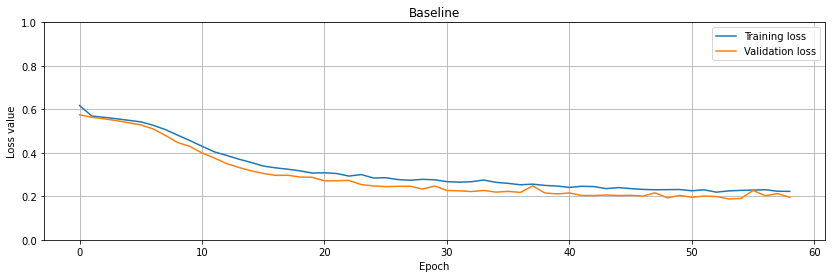

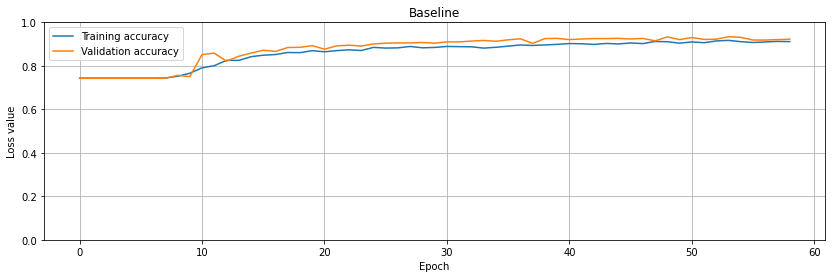

5/5 [==============================] - 3s 47ms/step - loss: 0.4071 - accuracy: 0.8237 - precision_1: 0.7917 - recall_1: 0.9744 - auc_roc: 0.9298 - auc_pr: 0.9559
{'loss': 0.4070851504802704, 'accuracy': 0.8237179517745972, 'precision_1': 0.7916666865348816, 'recall_1': 0.9743589758872986, 'auc_roc': 0.9297884702682495, 'auc_pr': 0.9558999538421631}


In [ ]:
train_model("Baseline")

Found 4178 images belonging to 2 classes.
Found 1046 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
33
Epoch 1/100
33/33 - 102s - loss: 1.5344 - accuracy: 0.7202 - precision: 0.8146 - recall: 0.8075 - auc_roc: 0.6777 - auc_pr: 0.8303 - val_loss: 0.6511 - val_accuracy: 0.8011 - val_precision: 0.9317 - val_recall: 0.7902 - val_auc_roc: 0.8833 - val_auc_pr: 0.9485
Epoch 2/100
33/33 - 95s - loss: 0.7044 - accuracy: 0.8506 - precision: 0.9050 - recall: 0.8928 - auc_roc: 0.8787 - auc_pr: 0.9363 - val_loss: 0.4711 - val_accuracy: 0.8719 - val_precision: 0.9586 - val_recall: 0.8649 - val_auc_roc: 0.9376 - val_auc_pr: 0.9757
Epoch 3/100
33/33 - 96s - loss: 0.5403 - accuracy: 0.8870 - precision: 0.9324 - recall: 0.9144 - auc_roc: 0.9209 - auc_pr: 0.9585 - val_loss: 0.3611 - val_accuracy: 0.8891 - val_precision: 0.9401 - val_recall: 0.9086 - val_auc_roc: 0.9518 - val_auc_pr: 0.9803
Epoch 4/100
33/33 - 95s - loss: 0.4496 - accuracy: 0.9045 - precision: 0.9365 - recall: 0.935

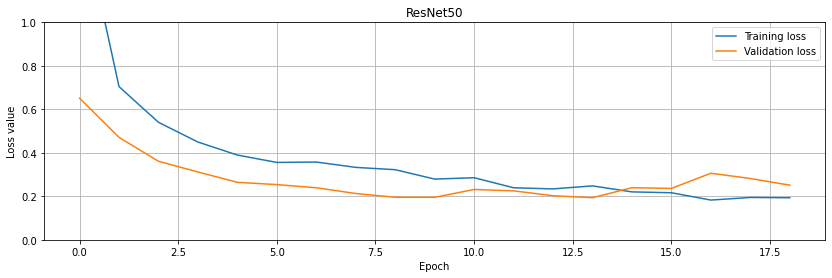

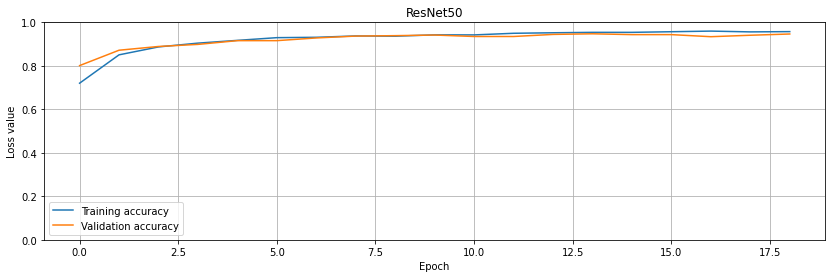

5/5 [==============================] - 5s 322ms/step - loss: 0.8550 - accuracy: 0.8478 - precision: 0.8132 - recall: 0.9821 - auc_roc: 0.8863 - auc_pr: 0.8869
{'loss': 0.8550172448158264, 'accuracy': 0.8477563858032227, 'precision': 0.8131634593009949, 'recall': 0.9820512533187866, 'auc_roc': 0.8862863779067993, 'auc_pr': 0.8868955373764038}


In [ ]:
train_model("ResNet50")

Found 4178 images belonging to 2 classes.
Found 1046 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
66
Epoch 1/100
66/66 - 117s - loss: 1.4966 - accuracy: 0.7472 - precision: 0.7584 - recall: 0.9684 - auc_roc: 0.5967 - auc_pr: 0.7866 - val_loss: 0.7170 - val_accuracy: 0.7629 - val_precision: 0.7632 - val_recall: 0.9871 - val_auc_roc: 0.7417 - val_auc_pr: 0.8736
Epoch 2/100
66/66 - 104s - loss: 0.6441 - accuracy: 0.7982 - precision: 0.8331 - recall: 0.9111 - auc_roc: 0.8159 - auc_pr: 0.9116 - val_loss: 0.4857 - val_accuracy: 0.8117 - val_precision: 0.8152 - val_recall: 0.9653 - val_auc_roc: 0.8629 - val_auc_pr: 0.9437
Epoch 3/100
66/66 - 104s - loss: 0.4574 - accuracy: 0.8439 - precision: 0.8895 - recall: 0.9021 - auc_roc: 0.8929 - auc_pr: 0.9524 - val_loss: 0.3201 - val_accuracy: 0.8623 - val_precision: 0.8800 - val_recall: 0.9434 - val_auc_roc: 0.9266 - val_auc_pr: 0.9729
Epoch 4/100
66/66 - 103s - loss: 0.4076 - accuracy: 0.8636 - precision: 0.9072 - recall: 0.

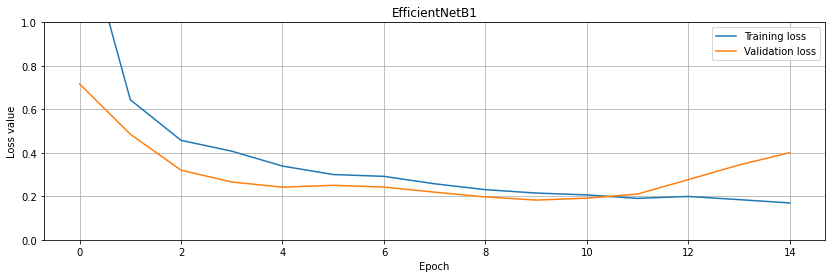

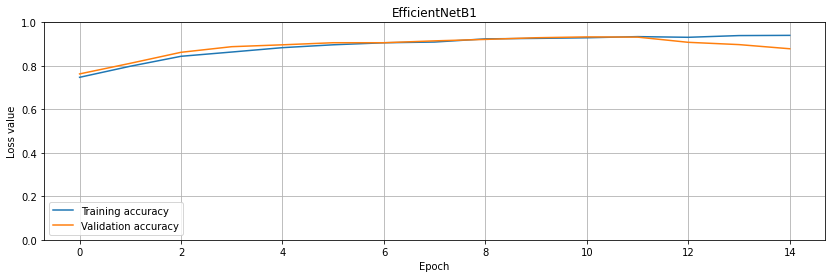

10/10 [==============================] - 5s 229ms/step - loss: 0.5175 - accuracy: 0.8221 - precision: 0.7949 - recall: 0.9641 - auc_roc: 0.9264 - auc_pr: 0.9462
{'loss': 0.5174986720085144, 'accuracy': 0.8221153616905212, 'precision': 0.7949259877204895, 'recall': 0.964102566242218, 'auc_roc': 0.926424503326416, 'auc_pr': 0.9461780786514282}


In [ ]:
train_model("EfficientNetB1", batch_size=64)

9412608/9406464 [==============================] - 0s 0us/step
Found 4178 images belonging to 2 classes.
Found 1046 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
33
Epoch 1/100
33/33 - 99s - loss: 0.8395 - accuracy: 0.7484 - precision: 0.8220 - recall: 0.8445 - auc_roc: 0.7454 - auc_pr: 0.8755 - val_loss: 0.6927 - val_accuracy: 0.7600 - val_precision: 0.7792 - val_recall: 0.9447 - val_auc_roc: 0.7179 - val_auc_pr: 0.8698
Epoch 2/100
33/33 - 91s - loss: 0.5593 - accuracy: 0.8265 - precision: 0.8910 - recall: 0.8735 - auc_roc: 0.8752 - auc_pr: 0.9445 - val_loss: 0.5772 - val_accuracy: 0.7830 - val_precision: 0.8009 - val_recall: 0.9421 - val_auc_roc: 0.8001 - val_auc_pr: 0.9157
Epoch 3/100
33/33 - 91s - loss: 0.4238 - accuracy: 0.8705 - precision: 0.9171 - recall: 0.9079 - auc_roc: 0.9165 - auc_pr: 0.9615 - val_loss: 0.5005 - val_accuracy: 0.8011 - val_precision: 0.8165 - val_recall: 0.9447 - val_auc_roc: 0.8493 - val_auc_pr: 0.9379
Epoch 4/100
33/33 - 91s - loss:

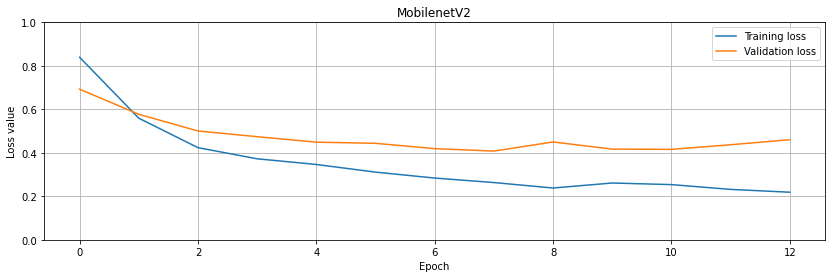

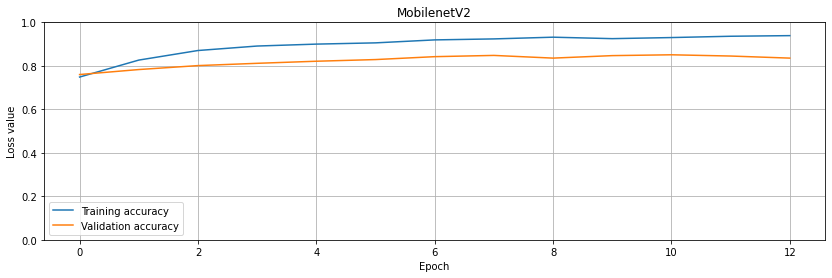

5/5 [==============================] - 4s 253ms/step - loss: 0.9644 - accuracy: 0.7083 - precision: 0.6871 - recall: 0.9795 - auc_roc: 0.8480 - auc_pr: 0.8784
{'loss': 0.9643880128860474, 'accuracy': 0.7083333134651184, 'precision': 0.6870503425598145, 'recall': 0.9794871807098389, 'auc_roc': 0.84803307056427, 'auc_pr': 0.8784315586090088}


In [ ]:
train_model("MobilenetV2")

Found 4178 images belonging to 2 classes.
Found 1046 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
33
Epoch 1/100
33/33 - 105s - loss: 0.8020 - accuracy: 0.6108 - precision: 0.8001 - recall: 0.6352 - auc_roc: 0.6441 - auc_pr: 0.8428 - val_loss: 0.8534 - val_accuracy: 0.7428 - val_precision: 0.7438 - val_recall: 0.9974 - val_auc_roc: 0.7615 - val_auc_pr: 0.8945
Epoch 2/100
33/33 - 93s - loss: 0.3782 - accuracy: 0.8334 - precision: 0.8731 - recall: 0.9079 - auc_roc: 0.8773 - auc_pr: 0.9468 - val_loss: 0.7533 - val_accuracy: 0.7486 - val_precision: 0.7476 - val_recall: 0.9987 - val_auc_roc: 0.8979 - val_auc_pr: 0.9567
Epoch 3/100
33/33 - 93s - loss: 0.2531 - accuracy: 0.9055 - precision: 0.9324 - recall: 0.9411 - auc_roc: 0.9452 - auc_pr: 0.9768 - val_loss: 0.7025 - val_accuracy: 0.7639 - val_precision: 0.7593 - val_recall: 0.9987 - val_auc_roc: 0.9441 - val_auc_pr: 0.9720
Epoch 4/100
33/33 - 93s - loss: 0.2158 - accuracy: 0.9201 - precision: 0.9428 - recall: 0.950

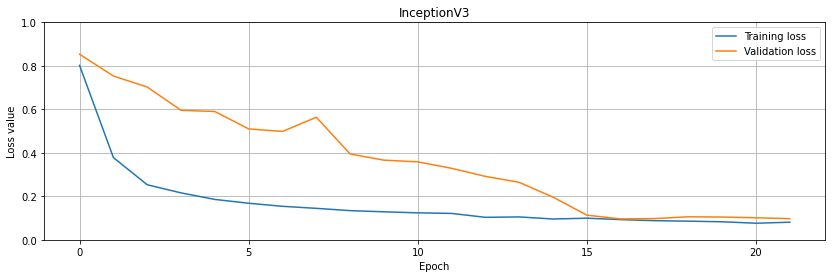

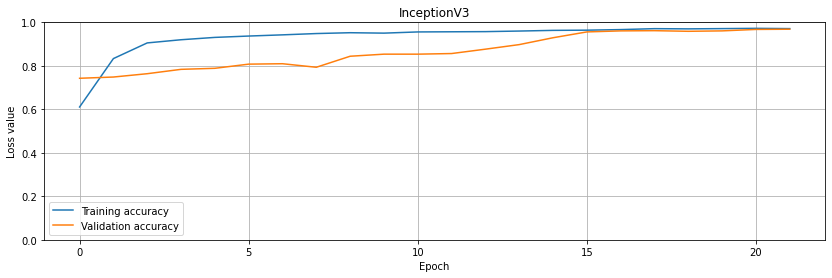

5/5 [==============================] - 6s 617ms/step - loss: 0.6932 - accuracy: 0.7965 - precision: 0.7553 - recall: 0.9974 - auc_roc: 0.9290 - auc_pr: 0.9297
{'loss': 0.6931901574134827, 'accuracy': 0.7964743375778198, 'precision': 0.7553398013114929, 'recall': 0.9974358677864075, 'auc_roc': 0.9289996027946472, 'auc_pr': 0.9296755194664001}


In [ ]:
train_model("InceptionV3")

In [ ]:
import pandas as pd
metrics = {
    "Baseline": {'loss': 0.4070851504802704, 'accuracy': 0.8237179517745972, 'precision': 0.7916666865348816, 'recall': 0.9743589758872986, 'auc_roc': 0.9297884702682495, 'auc_pr': 0.9558999538421631},
    "MobileNet V2": {'loss': 0.9643880128860474, 'accuracy': 0.7083333134651184, 'precision': 0.6870503425598145, 'recall': 0.9794871807098389, 'auc_roc': 0.84803307056427, 'auc_pr': 0.8784315586090088},
    "Inception V3": {'loss': 0.6931901574134827, 'accuracy': 0.7964743375778198, 'precision': 0.7553398013114929, 'recall': 0.9974358677864075, 'auc_roc': 0.9289996027946472, 'auc_pr': 0.9296755194664001},
    "ResNet50 V2": {'loss': 0.8550172448158264, 'accuracy': 0.8477563858032227, 'precision': 0.8131634593009949, 'recall': 0.9820512533187866, 'auc_roc': 0.8862863779067993, 'auc_pr': 0.8868955373764038},
    "EfficientNet B1": {'loss': 0.5174986720085144, 'accuracy': 0.8221153616905212, 'precision': 0.7949259877204895, 'recall': 0.964102566242218, 'auc_roc': 0.926424503326416, 'auc_pr': 0.9461780786514282},
}
metrics_df = pd.DataFrame(metrics).T
metrics_df

,loss,accuracy,precision,recall,auc_roc,auc_pr
Baseline,0.407085,0.823718,0.791667,0.974359,0.929788,0.955900
MobileNet V2,0.964388,0.708333,0.687050,0.979487,0.848033,0.878432
Inception V3,0.693190,0.796474,0.755340,0.997436,0.929000,0.929676
ResNet50 V2,0.855017,0.847756,0.813163,0.982051,0.886286,0.886896
EfficientNet B1,0.517499,0.822115,0.794926,0.964103,0.926425,0.946178
